In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import geocat.comp as gc
#import geocat.datafiles as gcd


In [2]:
def plot_variable_with_shapefiles(
    data, lon, lat, title, units, ax=None,
    cmap="RdBu_r", levels=21, shapefiles=None,
    extent=[65, 85, 0, 20], add_colorbar=True
):
    """
    Plots an ERA5 variable with shapefile overlay on a given axis (ax).

    Parameters:
        data : 2D numpy array
        lon, lat : 1D or 2D longitude/latitude arrays
        title : str
        units : str
        ax : matplotlib Axes (with Cartopy) — required for subplots
        cmap : str or Colormap
        levels : int or list of contour levels
        shapefiles : list of GeoDataFrames
        extent : [lon_min, lon_max, lat_min, lat_max]
        add_colorbar : bool (to control per-subplot or global colorbar)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    cf = ax.contourf(
        lon, lat, data,
        levels=levels,
        cmap=cmap,
        extend='both',
        transform=ccrs.PlateCarree()
    )

    if shapefiles:
        for shp in shapefiles:
            shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(title, fontsize=14)

    # Gridlines and ticks
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}
    gl.xlocator = plt.FixedLocator(np.arange(extent[0], extent[1]+1, 5))
    gl.ylocator = plt.FixedLocator(np.arange(extent[2], extent[3]+1, 5))

    if add_colorbar:
        cbar = plt.colorbar(cf, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
        cbar.set_label(units)

    return cf  # so you can add a shared colorbar if needed


In [3]:
# Load shapefiles
wg = gpd.read_file("/Users/subin/Downloads/Shape_files/wg_bnd/wg_bnd.shp")  # Western Ghats or region boundary
world = gpd.read_file("/Users/subin/Downloads/Shape_files/world_boundaries/World_Countries_shp.shp")

# Ensure shapefiles are in WGS84
wg = wg.to_crs("EPSG:4326")
world = world.to_crs("EPSG:4326")

# Define bounding box: (minx, miny, maxx, maxy) = (lon_min, lat_min, lon_max, lat_max)
bbox = (65, 0, 85, 20)

# Clip using GeoDataFrame's .cx spatial indexer
world_clipped = world.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

In [4]:

# Define paths to files
file_hourly = "ERA5_29July2024_TWV.nc"
file_monthly = "ERA5_July_Clim_TWV.nc"

# Open datasets (cfgrib engine must be installed)
ds_hourly = xr.open_dataset(file_hourly)
ds_monthly = xr.open_dataset(file_monthly)


In [5]:

# Average hourly data into daily mean
ds_daily = ds_hourly.mean(dim="valid_time")
ds_monthly = ds_monthly.mean(dim="valid_time") # to remove time dimension


In [6]:
lat = ds_monthly.latitude.values
lon = ds_monthly.longitude.values

In [7]:
tcwv = ds_daily['tcwv']
tcwv_m = ds_monthly['tcwv']
tcwv_ano = tcwv - tcwv_m

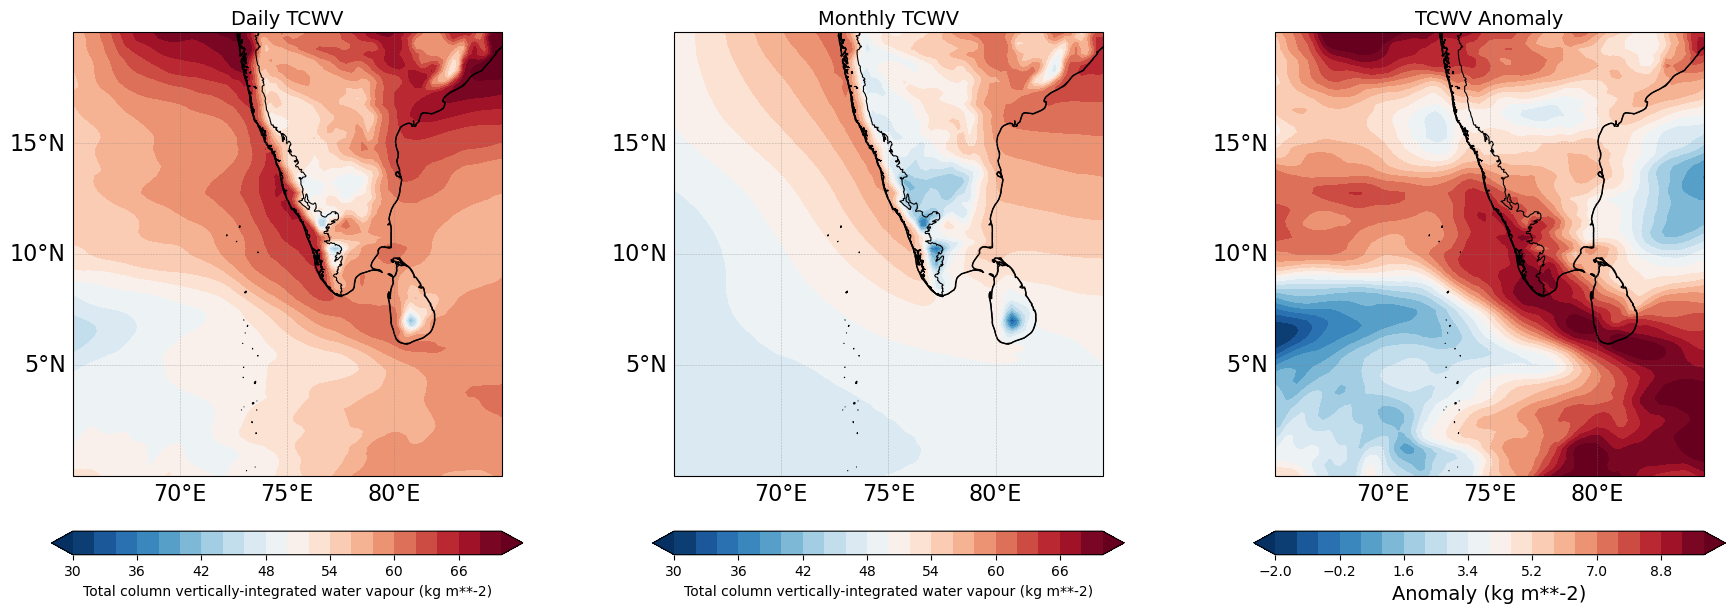

In [8]:
# plot


fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(tcwv, lon, lat, "Daily TCWV", "kg m**-2", ax=axs[0],
                                    levels=np.linspace(30,70, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf2 = plot_variable_with_shapefiles(tcwv_m, lon, lat, "Monthly TCWV", "kg m**-2", ax=axs[1],
                                    levels=np.linspace(30,70, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

cf3 = plot_variable_with_shapefiles(tcwv_ano, lon, lat, "TCWV Anomaly", "kg m**-2", ax=axs[2],
                                    levels=np.linspace(-2,10, 21), shapefiles=[world_clipped, wg], add_colorbar=False)

# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Total column vertically-integrated water vapour (kg m**-2)")
fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Total column vertically-integrated water vapour (kg m**-2)")
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly (kg m**-2)",fontsize = 14)
plt.savefig("Total column vertically-integrated water vapour.png", dpi=300, bbox_inches='tight')
plt.show()